In [4]:
from matplotlib           import pyplot as plt
from IPython.display      import Image
import matplotlib.pyplot  as plt
import tensorflow         as tf
import numpy              as np
import pandas             as pd

In [5]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

## Transforming data

In [18]:
data = data[data['Country/Region'] == 'Guatemala']
data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21
138,NaN,Guatemala,15.7835,-90.2308,0,0,0,0,0,0,...,247106,247454,247644,248824,250296,251336,252929,253837,254225,254417


In [31]:
feature_names = ["Province/State", "Country/Region", "Lat", "Long"]
date_names = list(data.columns[4:])

In [63]:
cleaned_data = data[date_names].T
cleaned_data.columns = ['confirmed']
cleaned_data['date'] = cleaned_data.index
cleaned_data = cleaned_data.reset_index(drop=True)
cleaned_data['date'] = pd.to_datetime(cleaned_data["date"], infer_datetime_format = True)
cleaned_data = cleaned_data[cleaned_data['confirmed'] > 0]
cleaned_data = cleaned_data[cleaned_data['date'] < '2020-06-01']
cleaned_data

,confirmed,date
52,1,2020-03-14
53,1,2020-03-15
54,2,2020-03-16
55,6,2020-03-17
56,6,2020-03-18
...,...,...
126,4145,2020-05-27
127,4348,2020-05-28
128,4607,2020-05-29
129,4739,2020-05-30


## Data Visualization

<AxesSubplot:xlabel='date', ylabel='confirmed'>

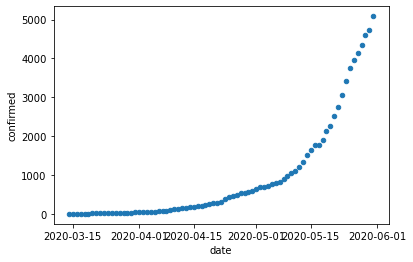

In [64]:
cleaned_data.plot.scatter(x = "date", y="confirmed")

## Data normalization

<AxesSubplot:xlabel='date', ylabel='ln(confirmed)'>

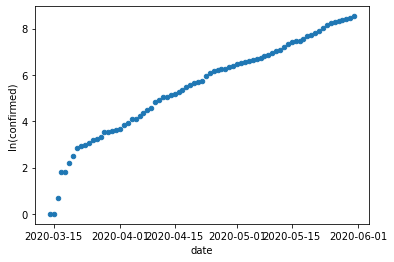

In [65]:
cleaned_data["ln(confirmed)"] = np.log(cleaned_data["confirmed"])
cleaned_data.plot.scatter(x = "date", y="ln(confirmed)")

<AxesSubplot:xlabel='date', ylabel='ln(confirmed)'>

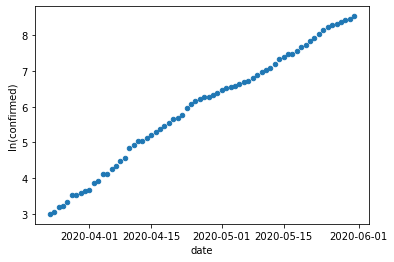

In [68]:
cleaned_data[cleaned_data['date'] > '2020-03-22'].plot.scatter(x = "date", y="ln(confirmed)")

## Defining Dataset

In [131]:
dataset = cleaned_data[cleaned_data['date'] > '2020-03-22']

## Transforming dates to int

In [132]:
dataset = dataset.reset_index(drop=True)
dataset['date_int'] = dataset.index
dataset

,confirmed,date,ln(confirmed),date_int
0,20,2020-03-23,2.995732,0
1,21,2020-03-24,3.044522,1
2,24,2020-03-25,3.178054,2
3,25,2020-03-26,3.218876,3
4,28,2020-03-27,3.332205,4
...,...,...,...,...
65,4145,2020-05-27,8.329658,65
66,4348,2020-05-28,8.377471,66
67,4607,2020-05-29,8.435332,67
68,4739,2020-05-30,8.463581,68


In [209]:
x = np.array(dataset['date_int'])
y = np.array(dataset['ln(confirmed)'])

## Model

In [251]:
class ModeloLineal:
    def __init__(self):
        tf.reset_default_graph()
        self.W = tf.get_variable("W", dtype=tf.float32, shape=[], initializer=tf.zeros_initializer())
        self.b = tf.get_variable("b", dtype=tf.float32, shape=[], initializer=tf.zeros_initializer())
        self.w_out = 0
        self.b_out = 0
        

    def predict(self, x):
        return tf.add(tf.multiply(self.W, x), self.b)
    
    def predict_out(self, x):
        return np.exp((x * self.w_out) + self.b_out)

    def update(self, x, y, learning_rate):
        prediction = self.predict(x)
        error = .5 * tf.reduce_mean(tf.math.square(y - prediction))
        gradient = tf.gradients(error, [self.W, self.b])
        updatew = tf.assign(self.W, self.W - learning_rate * gradient[0] )
        updateb = tf.assign(self.b, self.b - learning_rate * gradient[1] )
        update_params = tf.group(updatew, updateb)
        return update_params
    
    def mini_batches(self, x, y, batch_size):
        for batch_iteration in range(int(len(x)/batch_size)):
            init_batch = batch_iteration * batch_size
            end_batch = init_batch + batch_size
            yield np.array(x[init_batch:end_batch].reshape([-1,1])), np.array(y[init_batch:end_batch].reshape([-1,1]))
            
    def parse_config(self, config_string):
        parameters = {}
        for conf in config_string.split('_')[1:]:
            parameters[conf.split('=')[0]] = conf.split('=')[1]
        return parameters
        
    def train(self, x, y, conf_string):
        config = self.parse_config(conf_string)
        lr = float(config['lr'])
        epochs = int(config['epochs'])
        batch_size = int(config['batchsize'])
        log_epoch = int(config['logepoch'])
        
        tensor_x = tf.placeholder("float", name="tensor_x")
        tensor_y = tf.placeholder("float", name="tensor_y")
        
        prediction = self.predict(tensor_x)
        update_params = self.update(tensor_x, tensor_y, lr)
        error = .5 * tf.reduce_mean(tf.math.square(tensor_y - prediction))
        error_sum = tf.summary.scalar("Error", error)
        init = tf.global_variables_initializer()
        
        with tf.Session() as session:
            session.run(init)
            for epoch in range(epochs):
                for mini_x, mini_y in self.mini_batches(x, y, batch_size):
                    feed_dict = {tensor_x: mini_x, tensor_y: mini_y}    
                    session.run(update_params, feed_dict=feed_dict)
                    predictions = session.run(prediction, feed_dict=feed_dict)
                    
                if (epoch % log_epoch == 0):
                    w_value = session.run(self.W)
                    b_value = session.run(self.b)
                    error_value = session.run(error, feed_dict={tensor_x : x, tensor_y : y})
                    print(f"Epoch: {epoch}, W: {w_value}, b: {b_value}, error: {error_value}")
            
                    self.w_out = w_value
                    self.b_out = b_value

In [252]:
modelo = ModeloLineal()

In [265]:
configuration_string = "linearregression_epochs=30000_lr=0.001_batchsize=32_logepoch=2000"    

modelo.train(x, y, configuration_string)

Epoch: 0, W: 0.23546245694160461, b: 0.007792560383677483, error: 7.3097429275512695
Epoch: 2000, W: 0.092337965965271, b: 2.2374725341796875, error: 0.18780550360679626
Epoch: 4000, W: 0.08287061750888824, b: 2.913455009460449, error: 0.03146586939692497
Epoch: 6000, W: 0.0800040066242218, b: 3.118135929107666, error: 0.01541792880743742
Epoch: 8000, W: 0.07913599163293839, b: 3.180111885070801, error: 0.013427560217678547
Epoch: 10000, W: 0.07887320220470428, b: 3.198875665664673, error: 0.013087919913232327
Epoch: 12000, W: 0.07879355549812317, b: 3.2045631408691406, error: 0.013009101152420044
Epoch: 14000, W: 0.07876948267221451, b: 3.2062814235687256, error: 0.012987513095140457
Epoch: 16000, W: 0.07876408845186234, b: 3.206666946411133, error: 0.012982800602912903
Epoch: 18000, W: 0.07876408845186234, b: 3.206666946411133, error: 0.012982800602912903
Epoch: 20000, W: 0.07876408845186234, b: 3.206666946411133, error: 0.012982800602912903
Epoch: 22000, W: 0.07876408845186234, b: 3

In [271]:
dataset['predictions'] = modelo.predict_out(x)

## Real Data

<AxesSubplot:xlabel='date', ylabel='confirmed'>

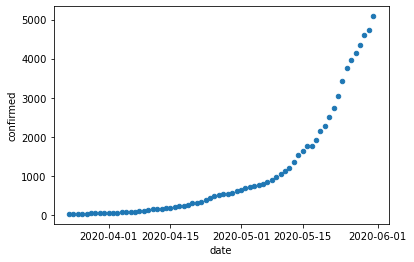

In [272]:
dataset.plot.scatter(x = "date", y="confirmed")

## Predicted Data

<AxesSubplot:xlabel='date', ylabel='predictions'>

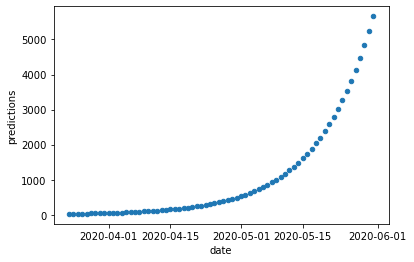

In [273]:
dataset.plot.scatter(x = "date", y="predictions")